## Dataclass

In [1]:
import torch.nn.functional as F
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F

class SongDetectorDataClass(Dataset):
    def __init__(self, file_dir):
        self.file_paths = []

        for file in os.listdir(file_dir):
            self.file_paths.append(os.path.join(file_dir, file))

    def __getitem__(self, index):        
        file_path = self.file_paths[index]

        data = np.load(file_path, allow_pickle=True)
        spectogram = data['s']
        ground_truth_labels = data['song']

        # This needs to be done because we are no longer operating on preprocessed data 
        # Z-score normalization
        mean_val, std_val = spectogram.mean(), spectogram.std()
        spectogram = (spectogram - mean_val) / (std_val + 1e-7)
        spectogram[np.isnan(spectogram)] = 0
        # spectogram = spectogram[20:216, :]

        ground_truth_labels = torch.tensor(ground_truth_labels, dtype=torch.int64).squeeze(0)
        spectogram = torch.from_numpy(spectogram).float().permute(1, 0)

        return spectogram.T, ground_truth_labels

    def __len__(self):
        return len(self.file_paths)

class CollateFunctionSongDetection:
    def __init__(self, segment_length=768):
        self.segment_length = segment_length

    def __call__(self, batch):
        # Unzip the batch
        spectograms, ground_truth_labels = zip(*batch)

        # Create lists to hold the processed tensors
        spectograms_processed = []
        ground_truth_labels_processed = []

        for spectogram, ground_truth_label in zip(spectograms, ground_truth_labels):            
            if spectogram.shape[1] < self.segment_length:
                pad_amount = self.segment_length - spectogram.shape[1]
                spectogram = F.pad(spectogram, (0, pad_amount), 'constant', 0)
                ground_truth_label = F.pad(ground_truth_label, (pad_amount,), 'constant', 0)  # Padding labels with -1 or another flag value
                ground_truth_labels_processed.append(ground_truth_label)

            # Truncate if larger than context window
            if spectogram.shape[1] > self.segment_length:
                # get random view of size segment
                # find range of valid starting pts (essentially these are the possible starting pts for the length to equal segment window)
                starting_points_range = spectogram.shape[1] - self.segment_length        
                start = torch.randint(0, starting_points_range, (1,)).item()  
                end = start + self.segment_length     

                spectogram = spectogram[:, start:end]
                ground_truth_label = ground_truth_label[start:end]

            spectograms_processed.append(spectogram)
            ground_truth_labels_processed.append(ground_truth_label)


        # Stack tensors along a new dimension
        spectograms = torch.stack(spectograms_processed, dim=0)
        spectograms = spectograms.unsqueeze(1)
        ground_truth_labels = torch.stack(ground_truth_labels_processed, dim=0)

        return spectograms, ground_truth_labels


In [2]:
from torch.utils.data import DataLoader

collate_fn = CollateFunctionSongDetection(segment_length=768)

test_class = SongDetectorDataClass("/home/george-vengrovski/Documents/data/tweety_net_test")
test_loader = DataLoader(test_class, batch_size=24, shuffle=True, num_workers=16, collate_fn=collate_fn)

train_class = SongDetectorDataClass("/home/george-vengrovski/Documents/data/tweety_net_train")
train_loader = DataLoader(test_class, batch_size=24, shuffle=True, num_workers=16, collate_fn=collate_fn)

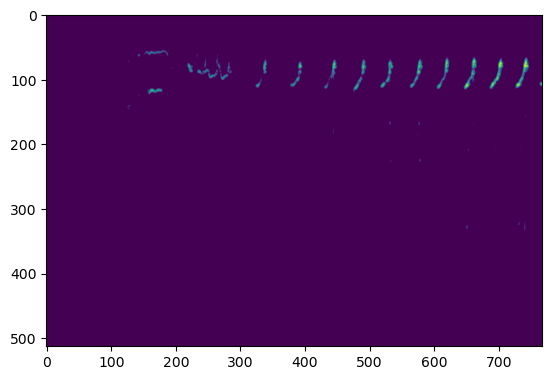

In [3]:
_, s = next(iter(test_loader))
import matplotlib.pyplot as plt

plt.imshow(_[0,0])

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt
import random

class Conv2dTF(nn.Conv2d):

    PADDING_METHODS = ('VALID', 'SAME')

    """Conv2d with padding behavior from Tensorflow
    adapted from
    https://github.com/mlperf/inference/blob/16a5661eea8f0545e04c86029362e22113c2ec09/others/edge/object_detection/ssd_mobilenet/pytorch/utils.py#L40
    as referenced in this issue:
    https://github.com/pytorch/pytorch/issues/3867#issuecomment-507025011
    used to maintain behavior of original implementation of TweetyNet that used Tensorflow 1.0 low-level API
    """
    def __init__(self, *args, **kwargs):
        # remove 'padding' from ``kwargs`` to avoid bug in ``torch`` => 1.7.2
        # see https://github.com/yardencsGitHub/tweetynet/issues/166
        kwargs_super = {k: v for k, v in kwargs.items() if k != 'padding'}
        super(Conv2dTF, self).__init__(*args, **kwargs_super)
        padding = kwargs.get("padding", "SAME")
        if not isinstance(padding, str):
            raise TypeError(f"value for 'padding' argument should be a string, one of: {self.PADDING_METHODS}")
        padding = padding.upper()
        if padding not in self.PADDING_METHODS:
            raise ValueError(
                f"value for 'padding' argument must be one of '{self.PADDING_METHODS}' but was: {padding}"
            )
        self.padding = padding

    def _compute_padding(self, input, dim):
        input_size = input.size(dim + 2)
        filter_size = self.weight.size(dim + 2)
        effective_filter_size = (filter_size - 1) * self.dilation[dim] + 1
        out_size = (input_size + self.stride[dim] - 1) // self.stride[dim]
        total_padding = max(
            0, (out_size - 1) * self.stride[dim] + effective_filter_size - input_size
        )
        additional_padding = int(total_padding % 2 != 0)

        return additional_padding, total_padding

    def forward(self, input):
        if self.padding == "VALID":
            return F.conv2d(
                input,
                self.weight,
                self.bias,
                self.stride,
                padding=0,
                dilation=self.dilation,
                groups=self.groups,
            )
        elif self.padding == "SAME":
            rows_odd, padding_rows = self._compute_padding(input, dim=0)
            cols_odd, padding_cols = self._compute_padding(input, dim=1)
            if rows_odd or cols_odd:
                input = F.pad(input, [0, cols_odd, 0, rows_odd])

            return F.conv2d(
                input,
                self.weight,
                self.bias,
                self.stride,
                padding=(padding_rows // 2, padding_cols // 2),
                dilation=self.dilation,
                groups=self.groups,
            )

class TweetyNet(nn.Module):
    def __init__(self,
                 num_classes,
                 input_shape=(1, 512, 768),
                 padding='SAME',
                 conv1_filters=32,
                 conv1_kernel_size=(5, 5),
                 conv2_filters=64,
                 conv2_kernel_size=(5, 5),
                 pool1_size=(14, 1),
                 pool1_stride=(14, 1),
                 pool2_size=(14, 1),
                 pool2_stride=(14, 1),
                 hidden_size=512,
                 rnn_dropout=0.,
                 num_layers=1,
                 bidirectional=True,
                 ):
        """initialize TweetyNet model
        Parameters
        ----------
        num_classes : int
            number of classes to predict, e.g., number of syllable classes in an individual bird's song
        input_shape : tuple
            with 3 elements corresponding to dimensions of spectrogram windows: (channels, frequency bins, time bins).
            i.e. we assume input is a spectrogram and treat it like an image, typically with one channel,
            the rows are frequency bins, and the columns are time bins. Default is (1, 513, 88).
        padding : str
            type of padding to use, one of {"VALID", "SAME"}. Default is "SAME".
        conv1_filters : int
            Number of filters in first convolutional layer. Default is 32.
        conv1_kernel_size : tuple
            Size of kernels, i.e. filters, in first convolutional layer. Default is (5, 5).
        conv2_filters : int
            Number of filters in second convolutional layer. Default is 64.
        conv2_kernel_size : tuple
            Size of kernels, i.e. filters, in second convolutional layer. Default is (5, 5).
        pool1_size : two element tuple of ints    specs = self.transform(specs)

            Size of sliding window for first max pooling layer. Default is (1, 8)
        pool1_stride : two element tuple of ints
            Step size for sliding window of first max pooling layer. Default is (1, 8)
        pool2_size : two element tuple of ints
            Size of sliding window for second max pooling layer. Default is (1, 8),
        pool2_stride : two element tuple of ints
            Step size for sliding window of second max pooling layer. Default is (1, 8)
        hidden_size : int
            number of features in the hidden state ``h``. Default is None,
            in which case ``hidden_size`` is set to the dimensionality of the
            output of the convolutional neural network. This default maintains
            the original behavior of the network.
        rnn_dropout : float
            If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer,
            with dropout probability equal to dropout. Default: 0
        num_layers : int
            Number of recurrent layers. Default is 1.
        bidirectional : bool
            If True, make LSTM bidirectional. Default is True.
        """
        super().__init__()
        self.num_classes = num_classes
        self.input_shape = input_shape

        self.cnn = nn.Sequential(
            Conv2dTF(in_channels=self.input_shape[0],
                     out_channels=conv1_filters,
                     kernel_size=conv1_kernel_size,
                     padding=padding
                     ),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool1_size,
                         stride=pool1_stride),
            Conv2dTF(in_channels=conv1_filters,
                     out_channels=conv2_filters,
                     kernel_size=conv2_kernel_size,
                     padding=padding,
                     ),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool2_size,
                         stride=pool2_stride),
        )

        # determine number of features in output after stacking channels
        # we use the same number of features for hidden states
        # note self.num_hidden is also used to reshape output of cnn in self.forward method
        batch_shape = tuple((1,) + input_shape)
        tmp_tensor = torch.rand(batch_shape)
        tmp_out = self.cnn(tmp_tensor)
        channels_out, freqbins_out = tmp_out.shape[1], tmp_out.shape[2]
        self.rnn_input_size = channels_out * freqbins_out

        if hidden_size is None:
            self.hidden_size = self.rnn_input_size
        else:
            self.hidden_size = hidden_size

        self.rnn = nn.LSTM(input_size=self.rnn_input_size,
                           hidden_size=self.hidden_size,
                           num_layers=num_layers,
                           dropout=rnn_dropout,
                           bidirectional=bidirectional)

        # for self.fc, in_features = hidden_size * 2 because LSTM is bidirectional
        # so we get hidden forward + hidden backward as output
        self.fc = nn.Linear(in_features=self.hidden_size * 2, out_features=num_classes)

    def forward(self, x):
        features = self.cnn(x)
        # stack channels, to give tensor shape (batch, rnn_input_size, num time bins)
        features = features.view(features.shape[0], self.rnn_input_size, -1)
        # switch dimensions for feeding to rnn, to (num time bins, batch size, input size)
        features = features.permute(2, 0, 1)
        rnn_output, _ = self.rnn(features)
        # permute back to (batch, time bins, hidden size) to project features down onto number of classes
        rnn_output = rnn_output.permute(1, 0, 2)
        logits = self.fc(rnn_output)
        # permute yet again so that dimension order is (batch, classes, time steps)
        # because this is order that loss function expects
        return logits.permute(0, 2, 1)

    def loss_function(self, y_pred, y_true):
        """loss function for TweetyNet
        Parameters
        ----------
        y_pred : torch.Tensor
            output of TweetyNet model, shape (batch, classes, timebins)
        y_true : torch.Tensor
            one-hot encoded labels, shape (batch, classes, timebins)
        Returns
        -------
        loss : torch.Tensor
            mean cross entropy loss
        """
        loss = nn.BCELoss()
        return loss(y_pred, y_true)

In [5]:
class LinearProbeTrainer():
    def __init__(self, model, train_loader, test_loader, device, lr=1e-2, plotting=False, batches_per_eval=100, desired_total_batches=1e4, patience=8, use_tqdm=True, moving_avg_window = 200):
        self.device = device
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=1e-2, weight_decay=0.0)
        self.plotting = plotting
        self.batches_per_eval = batches_per_eval
        self.desired_total_batches = desired_total_batches
        self.patience = patience
        self.use_tqdm = use_tqdm
        self.moving_avg_window = moving_avg_window  # Window size for moving average

    def frame_error_rate(self, y_pred, y_true):
        
        # Threshold y_pred at 0.5 to obtain binary predictions
        y_pred_binary = (y_pred > 0.5).float()
        
        # Calculate mismatches between binary predictions and true labels
        mismatches = (y_pred_binary != y_true).float()
        
        # Compute the error rate
        error = mismatches.sum() / y_true.numel()
        
        return error * 100

    def validate_model(self):
        self.model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        total_frame_error = 0
        num_val_batches = 0

        with torch.no_grad():
            for i, (spectrogram, label) in enumerate(self.test_loader):
                if i > self.batches_per_eval:
                    break
                spectrogram, label = spectrogram.to(self.device), label.to(self.device).float()

                output = self.model.forward(spectrogram)
                output = output.squeeze(1)
                output = torch.sigmoid(output)
                loss = self.model.loss_function(y_pred=output, y_true=label)

                total_val_loss += loss.item()
                total_frame_error += self.frame_error_rate(output, label).item()
                num_val_batches += 1

        self.model.train()  # Set the model back to training mode
        avg_val_loss = total_val_loss / num_val_batches
        avg_frame_error = total_frame_error / num_val_batches
        return avg_val_loss, avg_frame_error

    def moving_average(self, values, window):
        """Simple moving average over a list of values"""
        weights = np.repeat(1.0, window) / window
        sma = np.convolve(values, weights, 'valid')
        return sma.tolist()

    def train(self):
        total_batches = 0
        best_val_loss = float('inf')
        num_val_no_improve = 0
        stop_training = False

        raw_loss_list, raw_val_loss_list, raw_frame_error_rate_list, smooth_train_loss = [], [], [], []

        while total_batches < self.desired_total_batches:
            for i, (spectrogram, label) in enumerate(self.train_loader):
                if total_batches >= self.desired_total_batches:
                    break

                spectrogram, label = spectrogram.to(self.device), label.to(self.device).float()  # Convert label to float

                output = self.model.forward(spectrogram)
                output = output.squeeze(1)
                output = torch.sigmoid(output)  # Apply sigmoid to output to get probabilities

                loss = self.model.loss_function(y_pred=output, y_true=label)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_batches += 1
                if total_batches % self.batches_per_eval == 0:
                    avg_val_loss, avg_frame_error = self.validate_model()

                    raw_loss_list.append(loss.item())
                    raw_val_loss_list.append(avg_val_loss)
                    raw_frame_error_rate_list.append(avg_frame_error)

                    if len(raw_val_loss_list) >= self.moving_avg_window:
                        smooth_train_loss = self.moving_average(raw_loss_list, self.moving_avg_window)[-1]
                        smooth_val_loss = self.moving_average(raw_val_loss_list, self.moving_avg_window)[-1]
                        if self.use_tqdm: 
                            print(f'Batch {total_batches}: FER = {avg_frame_error:.2f}%, Train Loss = {smooth_train_loss.item():.4f}, Val Loss = {smooth_val_loss:.4f}')
                        if smooth_val_loss < best_val_loss:
                            best_val_loss = smooth_val_loss
                            num_val_no_improve = 0
                        else:
                            num_val_no_improve += 1
                            if num_val_no_improve >= self.patience:
                                print("Early stopping triggered")
                                stop_training = True
                                break



                if stop_training:
                    break
            if stop_training:
                break

        if self.plotting:
            self.plot_results(smooth_train_loss, raw_val_loss_list, raw_frame_error_rate_list)

    def plot_results(self, loss_list, val_loss_list, frame_error_rate_list):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(loss_list, label='Training Loss')
        plt.plot(val_loss_list, label='Validation Loss')
        plt.title('Loss over Batches')
        plt.xlabel('Batches')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(frame_error_rate_list, label='Frame Error Rate', color='red')
        plt.title('Frame Error Rate over Batches')
        plt.xlabel('Batches')
        plt.ylabel('Error Rate (%)')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TweetyNet(hidden_size=384, rnn_dropout=0.2, num_classes=1)
model = model.to(device)

/home/george-vengrovski/anaconda3/envs/tweetybert/lib/python3.11/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [7]:
trainer = LinearProbeTrainer(model=model, train_loader=train_loader, test_loader=test_loader, device=device, lr=3e-4, plotting=True, batches_per_eval=10, desired_total_batches=5e3, patience=8)
trainer.train()

Batch 10: FER = 22.17%, Train Loss = 0.6304, Val Loss = 0.4766
Batch 20: FER = 23.86%, Train Loss = 0.1693, Val Loss = 0.4888
Batch 30: FER = 14.63%, Train Loss = 0.1869, Val Loss = 0.3592
Batch 40: FER = 15.96%, Train Loss = 0.1319, Val Loss = 0.4070
Batch 50: FER = 12.13%, Train Loss = 0.3631, Val Loss = 0.2740
Batch 60: FER = 19.76%, Train Loss = 0.0465, Val Loss = 0.3802
Batch 70: FER = 19.66%, Train Loss = 0.7299, Val Loss = 0.4000
Batch 80: FER = 22.98%, Train Loss = 0.1469, Val Loss = 0.4907
Batch 90: FER = 7.40%, Train Loss = 0.1819, Val Loss = 0.1898
Batch 100: FER = 10.96%, Train Loss = 0.0076, Val Loss = 0.2257
Batch 110: FER = 16.09%, Train Loss = 0.5152, Val Loss = 0.3801
Batch 120: FER = 10.42%, Train Loss = 0.5646, Val Loss = 0.2785
Batch 130: FER = 6.74%, Train Loss = 0.1337, Val Loss = 0.2112
Batch 140: FER = 8.68%, Train Loss = 0.4305, Val Loss = 0.1896
Batch 150: FER = 10.99%, Train Loss = 0.1959, Val Loss = 0.2686
Batch 160: FER = 13.31%, Train Loss = 0.1172, Val Lo

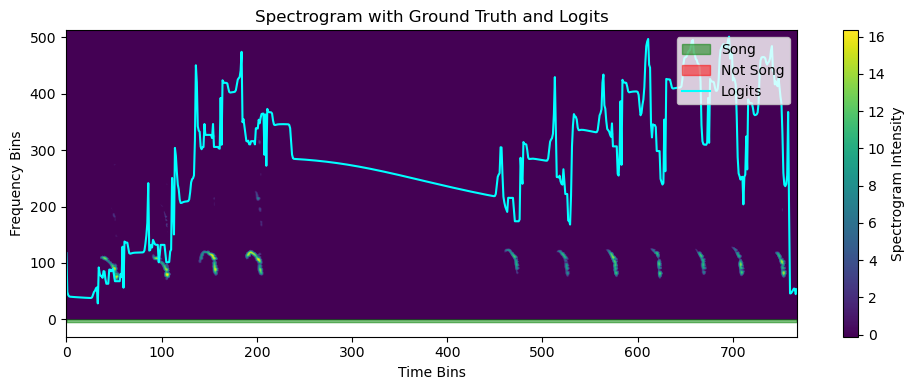

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def plot_spectrogram_with_labels_and_logits(spec, ground_truth_label, logits):
    # Apply sigmoid to logits to scale them between 0 and 1
    logits_sigmoid = sigmoid(logits.squeeze().detach().cpu().numpy())  # Ensure logits is 1D before applying sigmoid

    # Plotting
    plt.figure(figsize=(10, 4))

    # Plot spectrogram
    plt.imshow(spec.numpy(), aspect='auto', origin='lower')

    # Overlay ground truth labels as bars at the bottom
    times = np.arange(ground_truth_label.shape[0])
    song_bar_height = np.full_like(ground_truth_label.numpy(), -5)  # Slightly below the spectrogram
    not_song_bar_height = np.full_like(ground_truth_label.numpy(), -10)  # Further below for clarity

    plt.fill_between(times, song_bar_height, where=ground_truth_label.numpy() > 0.5, color='green', step='mid', alpha=0.5, label='Song')
    plt.fill_between(times, not_song_bar_height, where=ground_truth_label.numpy() <= 0.5, color='red', step='mid', alpha=0.5, label='Not Song')

    # Overlay logits as a line plot
    plt.plot(times, logits_sigmoid * (spec.shape[0] - 1), color='cyan', label='Logits')  # Scale logits to match spectrogram's frequency range

    plt.colorbar(label='Spectrogram Intensity')
    plt.xlabel('Time Bins')
    plt.ylabel('Frequency Bins')
    plt.title('Spectrogram with Ground Truth and Logits')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


# Example usage
# Assuming `test_loader`, `model`, and `device` are defined and initialized in your code
spec, ground_truth_label = next(iter(test_loader))  # Get a batch from your DataLoader

logit = model(spec.to(device))  # Get model predictions

# Use the first example in the batch for plotting
spec = spec[0]
ground_truth_label = ground_truth_label[0]
logit = logit[0]  # Adjust based on your model's output shape

# Remove channel dimension if present
if spec.dim() > 2:
    spec = spec.squeeze(0)

# Plot using the function
plot_spectrogram_with_labels_and_logits(spec.cpu(), ground_truth_label.cpu(), logit.cpu())
